## Model Selection Workflow

In [2]:
import os, glob
import site
site.addsitedir('/home/b3053674/Documents/pycotools')
from pycotools import model, tasks, viz, misc
import seaborn
%matplotlib inline
seaborn.set_context('notebook')

### Model Alternatives
In this tutorial we create three model alternatives using a PyCoTools wrapper around tellurium and antimony. Data is simualted from the negative feedback and model selection is performed to identify which of the three model candidates is the best fitting model. 

### Model Selection In Brief
To perform model selection using PyCoTools, put all of your models into a new directory along with your data files. The data files are exactly the same as you would use when fitting data with the COPASI GUI except that the headers must match model variables exactly. Then use the `tasks.MultiModelFit` class to use the `tasks.MultiParameterEstimation` class on each of the models on each of your models. After fitting, the `viz.ModelSelection` class to calculate AIC and BIC, and to plot model selection criteria. 

In [3]:
working_directory = r'/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration'

## create directory for our model selection analysis
model_selection_dir = os.path.join(working_directory, 'ModelSelection')

if not os.path.isdir(model_selection_dir):
    os.makedirs(model_selection_dir)
    
## create paths to three model alternatives. 
## This should be inside a new clean directory
copasi_file1 = os.path.join(model_selection_dir, 'negative_feedback.cps')
copasi_file2 = os.path.join(model_selection_dir, 'positive_feedback.cps')
copasi_file3 = os.path.join(model_selection_dir, 'feedforward.cps')

## build models with antimony
with model.BuildAntimony(copasi_file1) as loader:
    mod1 = loader.load(
        """
        model negative_feedback
            compartment cell = 1.0
            var A in cell
            var B in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            A = 0
            B = 0

            AProd: => A; cell*vAProd
            ADeg: A =>; cell*kADeg*A*B
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
        end
        """
    )

with model.BuildAntimony(copasi_file2) as loader:
    mod2 = loader.load(
        """
        model positive_feedback
            compartment cell = 1.0
            var A in cell
            var B in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            vBasalAProd = 0.001
            A = 0
            B = 0

            AProd: => A; cell*vAProd*B+vBasalAProd
            ADeg: A =>; cell*kADeg*A
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
        end
        """
    )

with model.BuildAntimony(copasi_file3) as loader:
    mod3 = loader.load(
        """
        model feed_forward
            compartment cell = 1.0
            var A in cell
            var B in cell
            var C in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            kCDeg = 0.5
            kCProd = 0.6
            A = 0
            B = 0
            C = 0

            AProd: => A; cell*vAProd
            ADeg: A =>; cell*kADeg*A
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
            CProd: => C; cell*kCProd*A*B
            CDeg: C => ; cell*kCDeg*C
        end
        """
    )

print(mod1)
print(mod2)
print(mod3)

Model(name=negative_feedback, time_unit=s, volume_unit=l, quantity_unit=mol)
Model(name=positive_feedback, time_unit=s, volume_unit=l, quantity_unit=mol)
Model(name=feedforward, time_unit=s, volume_unit=l, quantity_unit=mol)


### Simulate the Models

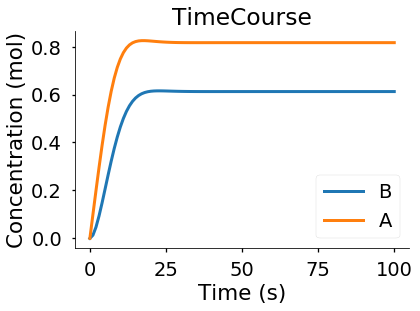

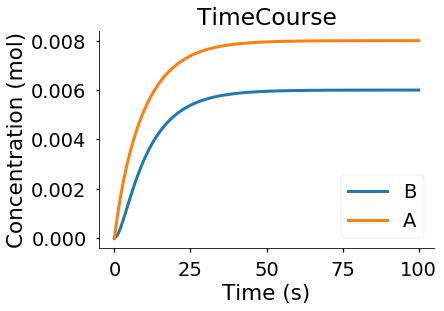

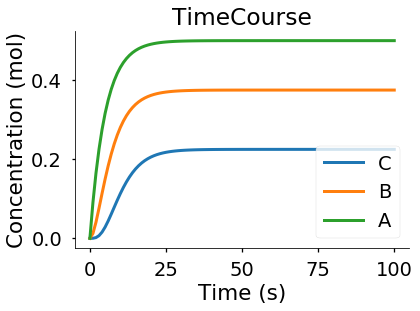

In [4]:
for mod in [mod1, mod2, mod3]:
    TC = tasks.TimeCourse(mod, end=100, intervals=100, step_size=1)
    viz.PlotTimeCourse(TC, separate=False)

### Simulate Synthetic Data

In [6]:
## Create time course data from negative feedback model
## This data is automatically saved as a report in the same directory as the model
TC = tasks.TimeCourse(mod1, end=100, intervals=10, step_size=10)

## Make sure that the headings inside the data file are identical to model variables (and not encloded by '[]'. )
misc.format_timecourse_data(TC.report_name) ##overwrites data file with new data file without the extra []

,Time,B,A,kBDeg,kBProd,kADeg,vAProd
0,0,0.000000,0.000000,0.4,0.3,0.2,0.1
1,10,0.464639,0.748359,0.4,0.3,0.2,0.1
2,20,0.613698,0.823275,0.4,0.3,0.2,0.1
3,30,0.613132,0.816723,0.4,0.3,0.2,0.1
4,40,0.612348,0.816455,0.4,0.3,0.2,0.1
5,50,0.612369,0.816496,0.4,0.3,0.2,0.1
6,60,0.612373,0.816497,0.4,0.3,0.2,0.1
7,70,0.612372,0.816497,0.4,0.3,0.2,0.1
8,80,0.612372,0.816497,0.4,0.3,0.2,0.1
9,90,0.612372,0.816497,0.4,0.3,0.2,0.1


### Perform Model Selection
Here we fit each model to the same data set which was simulated from the negative feedback model. We use the genetic algorithm 

In [7]:
MMF = tasks.MultiModelFit(model_selection_dir,
                          method='genetic_algorithm',
                          population_size=50,
                          number_of_generations=100,
                          copy_number=1,
                          pe_number=10,
                          run_mode=True,
                          overwrite_config_file=True,
                          lower_bound=1e-2,
                          upper_bound=1e2)
MMF.write_config_file()
MMF.setup()
MMF.run()

pycotools.tasks:INFO:4210:    project dir is --> /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection
pycotools.tasks:INFO:4175:    Creating workspace from project_dir
pycotools.tasks:INFO:4193:    Workspace created
pycotools.tasks:INFO:4156:    Running models from /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/negative_feedback/MultipleParameterEstimationResults
pycotools.tasks:INFO:3695:    running model: 0
pycotools.tasks:INFO:4156:    Running models from /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/positive_feedback/MultipleParameterEstimationResults
pycotools.tasks:INFO:3695:    running model: 0
pycotools.tasks:INFO:4156:    Running models from /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/feedforward/MultipleParameterEstimationResults
pycotools.tasks:INFO:3695:    running model: 0


### Calculate and Plot Model Selection Criteria 
Models are compared using violin plots which can be saved to file using the `savefig=True` argument. 
In a violin plot:
* The central spot is the median of the distribution
* The thin line down the middle represents the 95% confidence interval
* The thick centeral line represents the interquartile range
* The width of the violin is a kernel density estimation representing the shape of the data

pycotools.viz:INFO:3214:    Violin plot saved to : "/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ViolinPlot_RSS.png"
pycotools.viz:INFO:3214:    Violin plot saved to : "/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ViolinPlot_AICc.png"
pycotools.viz:INFO:3214:    Violin plot saved to : "/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ViolinPlot_BIC.png"
pycotools.viz:INFO:2961:    model selection data saved to /home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/ModelSelectionGraphs/ModelSelectionCriteria.csv


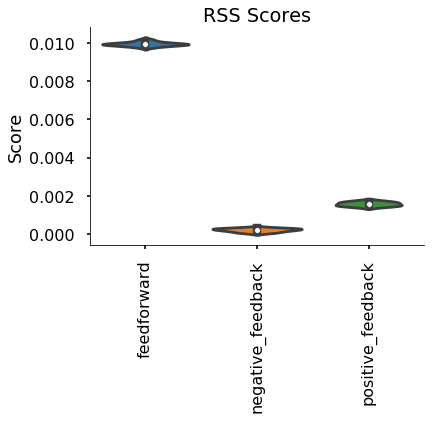

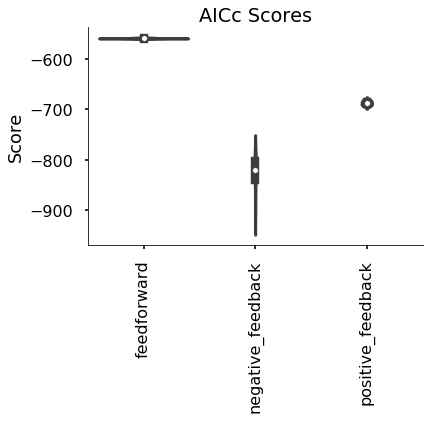

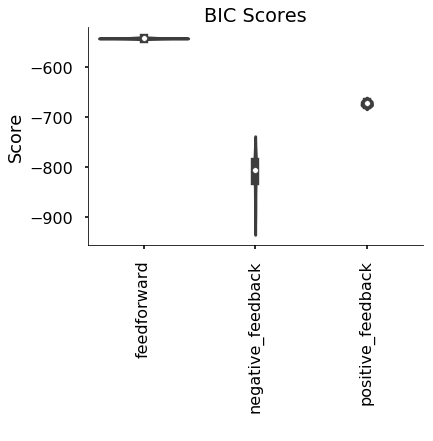

In [8]:
## Automatically produces Violin Plots and saves a csv file containing model selection criteria
MS = viz.ModelSelection(MMF, savefig=True)

Model selection criteria is also available from the `ModelSelection.model_selection_data` attribute.

In [9]:
MS.model_selection_data

feedforward                         negative_feedback              \
                 RSS        AICc         BIC               RSS        AICc   
RSS Rank                                                                     
0           0.009790 -560.859340 -544.152447          0.000062 -902.453506   
1           0.009883 -560.235198 -543.528305          0.000084 -882.547262   
2           0.009901 -560.114301 -543.407408          0.000155 -842.270781   
3           0.009912 -560.043081 -543.336188          0.000182 -831.765233   
4           0.009935 -559.886122 -543.179229          0.000217 -820.386713   
5           0.009968 -559.667004 -542.960112          0.000224 -818.049224   
6           0.009972 -559.644299 -542.937406          0.000285 -802.351930   
7           0.009984 -559.567237 -542.860344          0.000285 -802.272456   
8           0.010066 -559.021654 -542.314761          0.000294 -800.237442   
9           0.010177 -558.303058 -541.596165          0.000309 -796.954698   

                     positive_feedback                          
                 BIC               RSS        AICc         BIC  
RSS Rank                                                        
0        -890.315578          0.001432 -693.739523 -679.411940  
1        -870.409333          0.001449 -692.963699 -678.636116  
2        -830.132852          0.001505 -690.433821 -676.106238  
3        -819.627304          0.001512 -690.156435 -675.828852  
4        -808.248785          0.001528 -689.461977 -675.134394  
5        -805.911296          0.001614 -685.816661 -671.489078  
6        -790.214002          0.001621 -685.540879 -671.213296  
7        -790.134527          0.001646 -684.537686 -670.210102  
8        -788.099514          0.001721 -681.597681 -667.270098  
9        -784.816769          0.001721 -681.595380 -667.267797

### Best Parameters
Original Parameters were:
* A = 0
* B = 0
* kADeg = 0.2
* kBDeg = 0.4
* kBProd = 0.3
* vAProd = 0.1


Best estimated parameters for negative feedback model were:

In [15]:
## get key for negative feedback model
MMF.keys()

['/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/negative_feedback/negative_feedback.cps',
 '/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/positive_feedback/positive_feedback.cps',
 '/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/feedforward/feedforward.cps']

In [20]:
## Parse parameter estimation data into pandas.DataFrame
negetive_feedback_MPE = MMF['/home/b3053674/Documents/Models/2018/03_March/ModelSelectionDemonstration/ModelSelection/negative_feedback/negative_feedback.cps']
data = viz.Parse(negetive_feedback_MPE).data
data.iloc[0]

A         0.010416
B         0.011911
kADeg     0.198029
kBDeg     0.399129
kBProd    0.303652
vAProd    0.100465
RSS       0.000062
Name: 0, dtype: float64

### Interpretation
As expected, the RSS, AICc and BIC all support the negative feedback model as the model which best fits the data.

### Subsequent Analysis
The `tasks.MultiModelFit` object is a container object much like a dictionary for a series of `tasks.MultiParameterEstimation` objects. You can iterate over the `tasks.MultiModelFit` object to get a handle on each of the `tasks.MultiParameterEstimation` objects. Classes in the `viz` module can then be used to inspect the estimations. 

#### Ensemble Time Courses

pycotools.viz:DEBUG:1393:    tpe self.cls parse --> MultiParameterEstimation(copy_number="1", pe_number="10", method="genetic_algorithm")
pycotools.viz:INFO:1520:    Plotting "B"


/home/b3053674/anaconda2/envs/pycotools/lib/python2.7/site-packages/seaborn-0.8.1-py2.7.egg/seaborn/timeseries.py:184: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



pycotools.viz:INFO:1520:    Plotting "A"
pycotools.viz:DEBUG:1393:    tpe self.cls parse --> MultiParameterEstimation(copy_number="1", pe_number="10", method="genetic_algorithm")
pycotools.viz:INFO:1520:    Plotting "B"
pycotools.viz:INFO:1520:    Plotting "A"
pycotools.viz:DEBUG:1393:    tpe self.cls parse --> MultiParameterEstimation(copy_number="1", pe_number="10", method="genetic_algorithm")
pycotools.viz:INFO:1520:    Plotting "C"
pycotools.viz:INFO:1520:    Plotting "B"
pycotools.viz:INFO:1520:    Plotting "A"


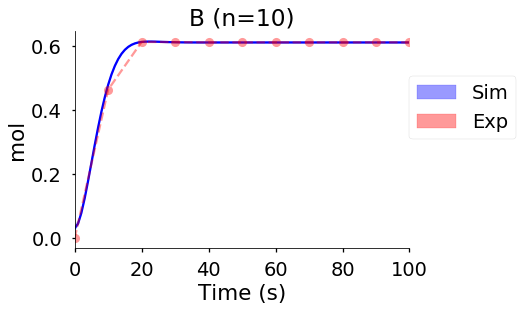

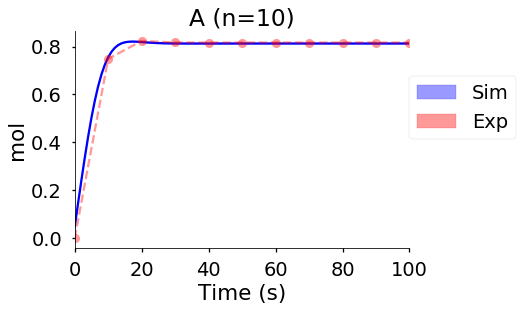

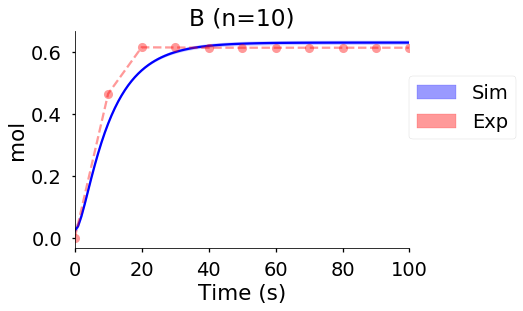

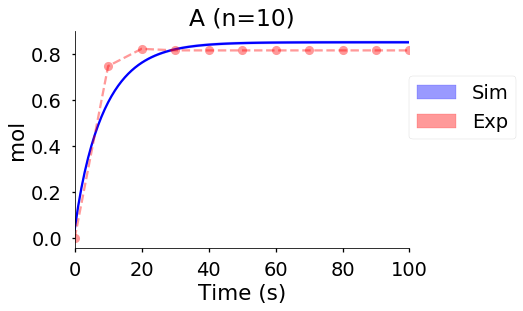

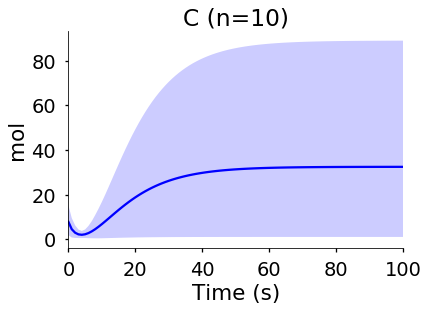

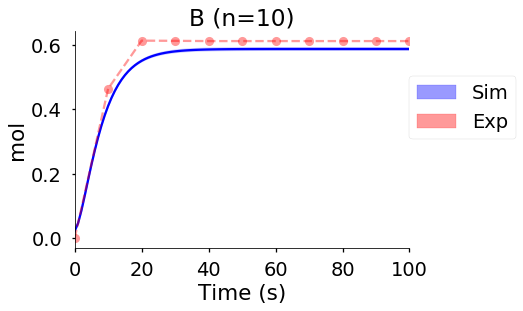

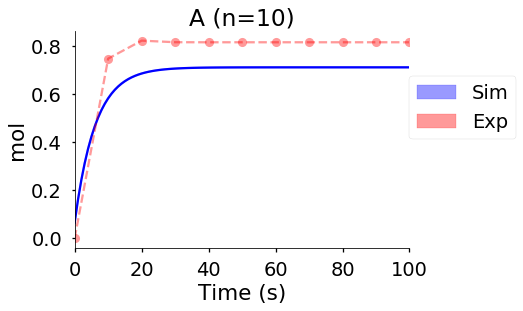

In [10]:
for MPE in MMF:
    ## 
    viz.PlotTimeCourseEnsemble(MPE, y=[i.name for i in MPE.model.metabolites])

#### Likelihood ranks

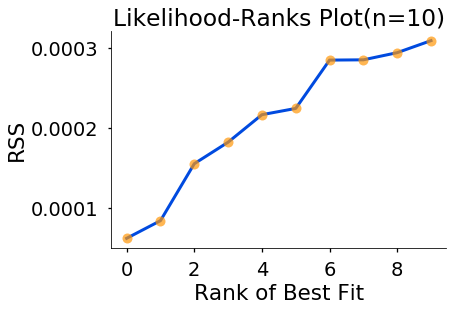

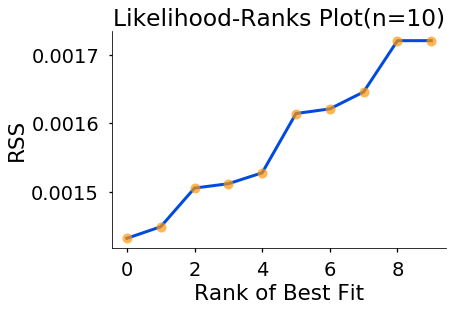

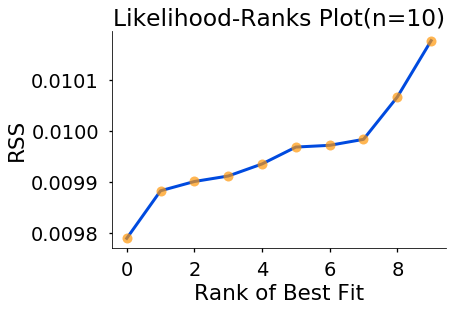

In [11]:
for MPE in MMF:
    viz.LikelihoodRanks(MPE)

#### Boxplots

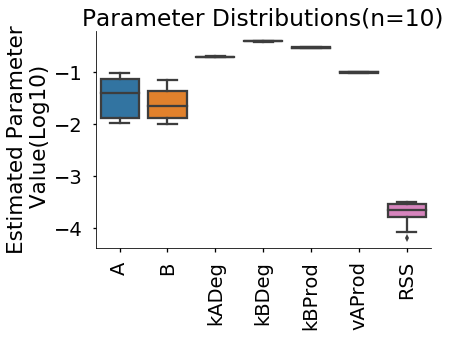

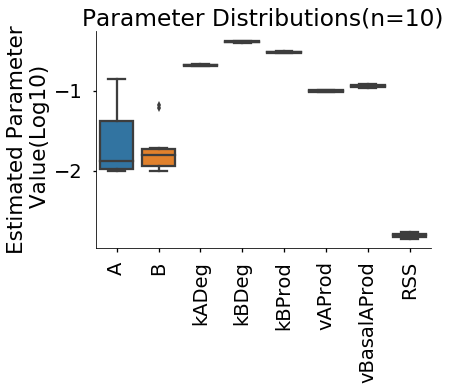

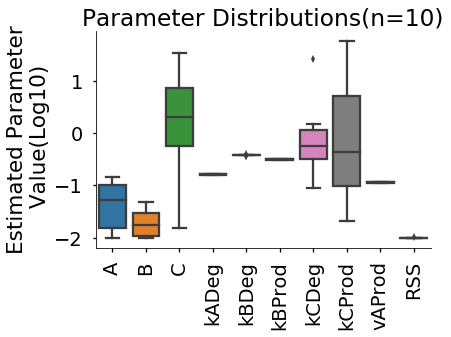

In [12]:
for MPE in MMF:
    viz.Boxplots(MPE, num_per_plot=10, log10=True)